# Linear regression

In [3]:
# Importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON, N3
#import lxml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import networkx as nx
#from networkx import Graph as NXGraph
#from rdflib import Graph as RDFGraph
#from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
#import statistics
#import collections
from scipy import stats
from scipy.stats import kstest
# https://www.statology.org/normality-test-python/

#from urllib import parse
from sklearn import linear_model
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

import mlnotify 
# https://github.com/aporia-ai/mlnotify
# Use %%notify at beginning of cell

import os.path, time
# Use %%time at beginning of cell

print('------------')
!python --version
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
#print("Seaborn " + sns.__version__)
#print("Networkx " + nx.__version__)
print('------------')
print("All packages loaded and ready to roll :-)")

------------
Python 3.7.6
Pandas 1.3.4
Numpy 1.18.1
------------
All packages loaded and ready to roll :-)


In [4]:
# Load GCM data

# NetworkX
#df_gcm = pd.read_csv('../data/gcm_computed.nosync/nx-gcm.csv')

# iGraph
df_ig_gcm = pd.read_csv('../data/gcm_computed.nosync/ig-gcm.csv')

df_ig_gcm.head()

,resource,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Billy_Coggins__Car...,3,7.845722e-04,5.936257e-08
1,http://dbpedia.org/ontology/CareerStation,1624880,1.000000e+00,2.791082e-02
2,http://dbpedia.org/resource/News_Patrol__A2Z_N...,9,7.198654e-11,1.150764e-07
3,http://dbpedia.org/resource/ZOE_Broadcasting_N...,20,9.183437e-10,2.792414e-07
4,http://dbpedia.org/resource/Yu_Yongfu,6,2.790954e-09,1.047756e-07


In [5]:
print("Data types:")
print(df_ig_gcm.dtypes)
print('----------------------')
print("Memory usage:")
print(df_ig_gcm.memory_usage(deep=True))
print('------------------------')
print("Dataframe shape is {}".format(df_ig_gcm.shape))

Data types:
resource        object
degree           int64
eigenvector    float64
pagerank       float64
dtype: object
----------------------
Memory usage:
Index                128
resource       964958363
degree          65946664
eigenvector     65946664
pagerank        65946664
dtype: int64
------------------------
Dataframe shape is (8243333, 4)


In [92]:
print("Correlation coefficient for ev-dg: ", np.corrcoef(df_ig_gcm.eigenvector, df_ig_gcm.degree))
print("Correlation coefficient for pr-dg: ", np.corrcoef(df_ig_gcm.pagerank, df_ig_gcm.degree))
print("Correlation coefficient for pr-ev: ", np.corrcoef(df_ig_gcm.pagerank, df_ig_gcm.eigenvector))

Correlation coefficient for ev-dg:  [[1.         0.60861409]
 [0.60861409 1.        ]]
Correlation coefficient for pr-dg:  [[1.         0.95806588]
 [0.95806588 1.        ]]
Correlation coefficient for pr-ev:  [[1.         0.52535622]
 [0.52535622 1.        ]]


In [6]:
# Load pre-queried (via queried web-interface) DBpedia categories
# https://dbpedia.org/sparql/

# 90s films from the aggregated Categories: 1990_films, 1991_films, 1992_films, ...
df_film90 = pd.read_csv("../data/sparql_cat_queries/sparql_90film.csv")
df_film90.rename(columns={"film90": "resource"}, inplace=True) #rename column to match PageRank dataframe

# actors from the "Occupation": "Actor"@en
df_actor = pd.read_csv("../data/sparql_cat_queries/sparql_actor.csv")
df_actor.rename(columns={"actor": "resource"}, inplace=True)

# Music Genre from the "Type": "dbo:MusicGenre"
df_musicGenre = pd.read_csv("../data/sparql_cat_queries/sparql_musicGenre.csv")
df_musicGenre.rename(columns={"mGenre": "resource"}, inplace=True)

# Books from the "Type":"dbo:book"
df_book = pd.read_csv("../data/sparql_cat_queries/sparql_book.csv")
df_book.rename(columns={"book": "resource"}, inplace=True)

# Book authors from the "Type": author UNION book dbo:author
df_bookAut = pd.read_csv("../data/sparql_cat_queries/sparql_bookAuthor.csv")
df_bookAut.rename(columns={"author": "resource"}, inplace=True)

# Politicians from the "Type": Person/Politician
df_pol = pd.read_csv("../data/sparql_cat_queries/sparql_politician.csv")
df_pol.rename(columns={"pol": "resource"}, inplace=True)

# POTUS from the "Category": Presidents_of_the_United_States
df_potus = pd.read_csv("../data/sparql_cat_queries/sparql_potus.csv")
df_potus.rename(columns={"potus": "resource"}, inplace=True)

# Cities from the "Category": "dbo:City"
df_city = pd.read_csv("../data/sparql_cat_queries/sparql_city.csv")
df_city.rename(columns={"city": "resource"}, inplace=True)

# Lakes from the "Category": "dbo:Lake"
df_lake = pd.read_csv("../data/sparql_cat_queries/sparql_lake.csv")
df_lake.rename(columns={"lake": "resource"}, inplace=True)

# Mountains from the "Category": "dbo:Mountain"
df_mountain = pd.read_csv("../data/sparql_cat_queries/sparql_mountain.csv")
df_mountain.rename(columns={"mount": "resource"}, inplace=True)

# EU capitals from the "Category": Capitals_in_Europe
df_euCap = pd.read_csv("../data/sparql_cat_queries/sparql_euCap.csv")
df_euCap.rename(columns={"euCap": "resource"}, inplace=True)

# EU countries from the "Category": Countries_in_Europe
df_euCou = pd.read_csv("../data/sparql_cat_queries/sparql_euCountry.csv")
df_euCou.rename(columns={"euCountry": "resource"}, inplace=True)

# Asian countries from the "Category": "dbc:Countries_in_Asia", "dbc:East_Asian_countries" and "dbc:Central_Asian_countries"
df_asCou = pd.read_csv("../data/sparql_cat_queries/sparql_asCountry.csv")
df_asCou.rename(columns={"asCountry": "resource"}, inplace=True)

# Continents from the "Category": "dbo:Continents"
df_continent = pd.read_csv("../data/sparql_cat_queries/sparql_continent.csv")
df_continent.rename(columns={"conti": "resource"}, inplace=True)

# Birds from the "Class": "dbr:Bird"
df_bird = pd.read_csv("../data/sparql_cat_queries/sparql_bird.csv")
df_bird.rename(columns={"bird": "resource"}, inplace=True)

# African animals from the "Category": "dbc:Vertebrates_of_Africa"
df_africanAnimal = pd.read_csv("../data/sparql_cat_queries/sparql_africanAnimal.csv")
df_africanAnimal.rename(columns={"afrAnimal": "resource"}, inplace=True)

# Furniture from the "Category": "dbc:Furniture"
df_furniture = pd.read_csv("../data/sparql_cat_queries/sparql_furniture.csv")
df_furniture.rename(columns={"fur": "resource"}, inplace=True)

# Furniture from the "Category": "dbc:Vegetables"
df_vegetable = pd.read_csv("../data/sparql_cat_queries/sparql_vegetable.csv")
df_vegetable.rename(columns={"veg": "resource"}, inplace=True)

# Types of fast food from the "Category": "dbc:Fast_food"
df_fastFood = pd.read_csv("../data/sparql_cat_queries/sparql_fastfood.csv")
df_fastFood.rename(columns={"fastFood": "resource"}, inplace=True)

# European Landmark/Sight from multiple "Category": "dbc:Landmarks_in_x" with x being a country from europe
df_euSight = pd.read_csv("../data/sparql_cat_queries/sparql_euLandmark.csv")
df_euSight.rename(columns={"euroSight": "resource"}, inplace=True)

# DAX company from the "Type": "dbo:Company" and "dbp:tradedAs" -> "dbr:DAX"
df_daxCo = pd.read_csv("../data/sparql_cat_queries/sparql_daxCompany.csv")
df_daxCo.rename(columns={"DAXco": "resource"}, inplace=True)

# US company from ?
df_usCo = pd.read_csv("../data/sparql_cat_queries/sparql_usCompany.csv")
df_usCo.rename(columns={"usCo": "resource"}, inplace=True)

# US tech company from the "Category": "dbc:Technology_companies_of_the_United_States"
df_usTechCo = pd.read_csv("../data/sparql_cat_queries/sparql_usTechCompany.csv")
df_usTechCo.rename(columns={"usTech": "resource"}, inplace=True)

In [12]:
# Function for standardized scaling and normalisation of GCM values
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

def scaler(data_frame):
    helper_df = data_frame.copy()
    to_scale = preprocessing.StandardScaler()

    helper_df[['degree', 'eigenvector', 'pagerank']] = to_scale.fit_transform(helper_df[['degree', 'eigenvector', 'pagerank']])
    return helper_df

#df_ig_gcm = scaler(df_ig_gcm)

In [73]:
# Function for merging the sparql category with GCM data

# Merge the queried category df to the GCM metrics based on <resource> with a left outer join
# (Keep every row in the category dataframe -> missing values get NaN)

def catMergerNorm(sparql_data, gcm_data):
    df_sparql = sparql_data.copy()
    df_gcm = gcm_data.copy()
    helper_df = pd.merge(df_sparql,
                 #df_gcm[['resource','degree','pagerank']],
                 df_gcm[['resource','degree', 'eigenvector', 'pagerank']],
                 on='resource', 
                 how='left')
    
    # scale and normalize the gcm metrics (same as scaler function)
    to_scale = preprocessing.StandardScaler()
    helper_df[['degree', 'eigenvector', 'pagerank']] = to_scale.fit_transform(helper_df[['degree', 'eigenvector', 'pagerank']])
    
    print("Dataframe merged with shape: {}".format(helper_df.shape))
    print('============================')

    #print(helper_df.shape[0] - helper_df.dropna().shape[0]) #return amount of rows containing NaN values
    
    return helper_df

def catMerger(sparql_data, gcm_data):
    df_sparql = sparql_data.copy()
    df_gcm = gcm_data.copy()
    helper_df = pd.merge(df_sparql,
                 #df_gcm[['resource','degree','pagerank']],
                 df_gcm[['resource','degree', 'eigenvector', 'pagerank']],
                 on='resource', 
                 how='left')
    
    # scale and normalize the gcm metrics (same as scaler function)
    #to_scale = preprocessing.StandardScaler()
    #helper_df[['degree', 'eigenvector', 'pagerank']] = to_scale.fit_transform(helper_df[['degree', 'eigenvector', 'pagerank']])
    
    print("Dataframe merged with shape: {}".format(helper_df.shape))
    print('============================')

    #print(helper_df.shape[0] - helper_df.dropna().shape[0]) #return amount of rows containing NaN values
    
    return helper_df

In [36]:
# Function for merging the survey category data with the gcm category data

# Merge the survey category df to the GCM metrics per category based on <resource> with a left outer join
# (Keep every row in the category dataframe -> missing values get NaN)

def prepSurGCMLinReg(survey_data, cat_gcm_data):
    df_survey = survey_data.copy()
    df_cat_gcm = cat_gcm_data.copy()
    df_survey.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe
        
    # Count how often an answer was given in the survey and save into new dataframe
    survey_count = df_survey['resource'].value_counts() #normalize values
    df_survey_counted = pd.DataFrame({'resource':survey_count.index, 'amount':survey_count.values})

    df_survey_gcm = pd.merge(df_survey_counted,
                df_cat_gcm[['resource','name', 'degree','eigenvector','pagerank']],
                #df_cat_gcm[['resource', 'degree','eigenvector','pagerank']],
                on='resource', 
                how='left')
    
    # Drop rows that were not matched with the category
    nan_rows = df_survey_gcm.shape[0] - df_survey_gcm.dropna().shape[0]    
    print("Rows with NaN values dropped: {}".format(nan_rows) + " from {}".format(df_survey_gcm.shape[0]) + " => {}% ".format(round((nan_rows/df_survey_gcm.shape[0])*100, 2))) #return amount of rows containing NaN values
    df_survey_gcm = df_survey_gcm.dropna()
    
    # Count how often an answer was given in the survey and save into new dataframe
    #df_survey_gcm['survey_mentions'] = df_survey_gcm['resource'].value_counts(normalize=True) #normalize values
    #df_survey_counted = pd.DataFrame({'resource':survey_count.index, 'amount':survey_count.values})
    
    # scale and normalize the survey data (same as scaler function)
    #to_scale = StandardScaler()
    #min_max_scaler = preprocessing.MinMaxScaler()
    #df_survey_gcm[['amount']] = min_max_scaler.fit_transform(df_survey_gcm[['amount']])
    df_survey_gcm['amount_rank'] = df_survey_gcm['amount']/np.sum(df_survey_gcm['amount'])

    
    print("Dataframe merged with shape: {}".format(df_survey_gcm.shape))
    
    return df_survey_gcm

In [74]:
euCap_result = catMerger(df_euCap, df_ig_gcm)

euCap_result.head()

Dataframe merged with shape: (52, 5)


,resource,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/European_Capital_o...,European Capital of Culture,1,1.081292e-08,4.602403e-08
1,http://dbpedia.org/resource/Podgorica,Podgorica,495,1.932748e-06,7.008188e-06
2,http://dbpedia.org/resource/City_of_San_Marino,City of San Marino,94,9.803589e-08,1.340477e-06
3,http://dbpedia.org/resource/Gibraltar,Gibraltar,553,5.106415e-07,8.827645e-06
4,http://dbpedia.org/resource/European_Youth_Cap...,European Youth Capital,2,1.629899e-11,5.269388e-08


<AxesSubplot:xlabel='eigenvector', ylabel='Density'>

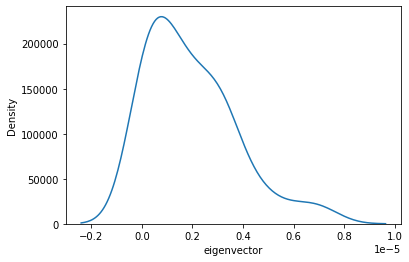

In [79]:
# Plot the kernel density estimate (KDE)
# -> method for visualizing the distribution of observations in a dataset, analagous to a histogram.
# KDE represents the data using a continuous probability density curve in one or more dimensions.
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

sns.kdeplot(euCap_result.eigenvector)

<AxesSubplot:xlabel='pagerank', ylabel='Density'>

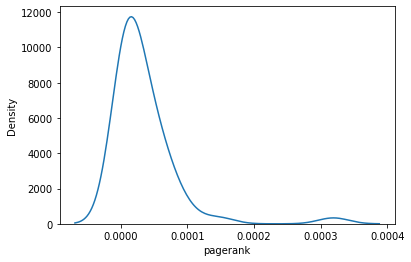

In [78]:
sns.kdeplot(euCap_result.pagerank)

<AxesSubplot:xlabel='degree', ylabel='Density'>

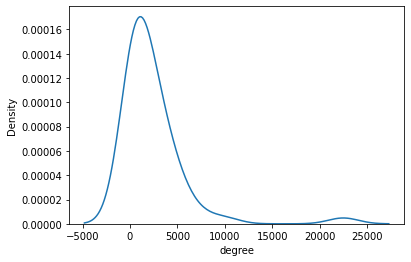

In [80]:
sns.kdeplot(euCap_result.degree)

In [75]:
euCap_resultNorm = catMergerNorm(df_euCap, df_ig_gcm)

euCap_resultNorm.head()

Dataframe merged with shape: (52, 5)


,resource,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/European_Capital_o...,European Capital of Culture,-0.676715,-1.107239,-0.691501
1,http://dbpedia.org/resource/Podgorica,Podgorica,-0.535232,-0.008673,-0.552313
2,http://dbpedia.org/resource/City_of_San_Marino,City of San Marino,-0.650080,-1.057383,-0.665622
3,http://dbpedia.org/resource/Gibraltar,Gibraltar,-0.518621,-0.821540,-0.515938
4,http://dbpedia.org/resource/European_Youth_Cap...,European Youth Capital,-0.676429,-1.113411,-0.691367


In [38]:
df_survey_euCap = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_capital_cities_impr.csv", sep=';')

df_euCap_survey_gcm = prepSurGCMLinReg(df_survey_euCap, euCap_result)

Rows with NaN values dropped: 4 from 28 => 14.29% 
Dataframe merged with shape: (24, 7)


In [39]:
df_euCap_survey_gcm

,resource,amount,name,degree,eigenvector,pagerank,amount_rank
0,http://dbpedia.org/resource/Berlin,84,Berlin,0.748426,-0.092511,0.773027,0.261682
1,http://dbpedia.org/resource/Paris,74,Paris,2.174713,0.671928,2.264122,0.230530
2,http://dbpedia.org/resource/London,45,London,5.766493,2.675248,5.688451,0.140187
3,http://dbpedia.org/resource/Rome,29,Rome,1.090678,0.751011,1.083243,0.090343
4,http://dbpedia.org/resource/Madrid,19,Madrid,0.611525,1.302521,0.638277,0.059190
5,http://dbpedia.org/resource/Vienna,9,Vienna,0.411903,0.363909,0.427952,0.028037
6,http://dbpedia.org/resource/City_of_Brussels,8,City of Brussels,-0.634328,-1.081555,-0.647325,0.024922
7,http://dbpedia.org/resource/Warsaw,7,Warsaw,0.196241,-0.650186,0.219633,0.021807
8,http://dbpedia.org/resource/Copenhagen,7,Copenhagen,0.307079,0.128754,0.397003,0.021807
9,http://dbpedia.org/resource/Helsinki,5,Helsinki,-0.014265,-0.510600,-0.003596,0.015576


In [72]:
np.corrcoef(df_euCap_survey_gcm.pagerank, df_euCap_survey_gcm.degree)

array([[1.        , 0.99954861],
       [0.99954861, 1.        ]])

In [71]:
%%time

#import statsmodels.api as sm

X = pd.DataFrame({"pagerank": df_euCap_survey_gcm.pagerank, "degree": df_euCap_survey_gcm.degree})
X = pd.DataFrame({"pagerank": df_euCap_survey_gcm.pagerank})

X = sm.add_constant(X, prepend=False)
Y = df_euCap_survey_gcm.amount_rank

# Fit and summarize OLS model
mod = sm.OLS(endog = Y, exog = X)

res = mod.fit()
robustreg = res.get_robustcov_results(cov_type='HAC',maxlags=1)

print(res.summary())
print(robustreg.summary())

                            OLS Regression Results                            
Dep. Variable:            amount_rank   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     9.477
Date:                Tue, 19 Jul 2022   Prob (F-statistic):            0.00550
Time:                        11:41:06   Log-Likelihood:                 34.347
No. Observations:                  24   AIC:                            -64.69
Df Residuals:                      22   BIC:                            -62.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pagerank       0.0304      0.010      3.078      0.0

In [61]:
pd.DataFrame({"pagerank": df_euCap_survey_gcm.pagerank, "degree": df_euCap_survey_gcm.degree})

,pagerank,degree
0,0.773027,0.748426
1,2.264122,2.174713
2,5.688451,5.766493
3,1.083243,1.090678
4,0.638277,0.611525
5,0.427952,0.411903
6,-0.647325,-0.634328
7,0.219633,0.196241
8,0.397003,0.307079
9,-0.003596,-0.014265
